In [162]:
import pandas as pd
df_all = pd.read_csv('data/cleaned/races.csv')
df_all = df_all[df_all['year'] > 2011]

print(len(df_all), "total races")

# Remove rows where "winner_party" or "runner_up_party" is "Other"
df = df_all[(df_all['winner_party'] != 'Other') & (df_all['runner_up_party'] != 'Other')]
print(len(df), "only republican and democrat")
df = df.dropna(subset=['winner_CAND_ICI', 'runner_up_CAND_ICI'])
print(len(df), "no na incumbent categories")
df['spending_ratio'] = df['spending_winner'] / df['spending_runner_up']

2057 total races
1916 only republican and democrat
1607 no na incumbent categories


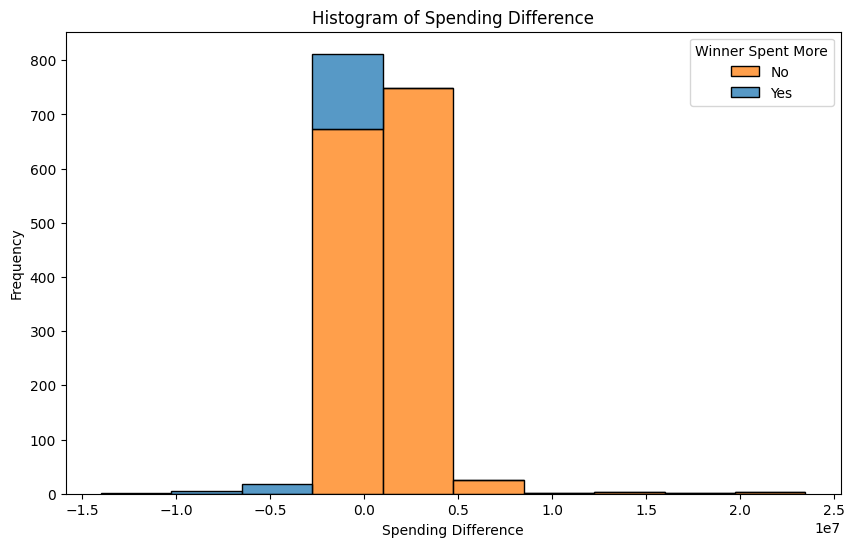

In [167]:
df_all['spending_diff'] = df_all['spending_winner'] - df_all['spending_runner_up']
df_all['winner_spent_more'] = df_all['spending_diff'] > 0

plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x='spending_diff', bins=10, hue='winner_spent_more', multiple='stack')
plt.title('Histogram of Spending Difference')
plt.xlabel('Spending Difference')
plt.ylabel('Frequency')
plt.legend(title='Winner Spent More', labels=['No', 'Yes'])
plt.show()


In [170]:
df_all[["winner_CAND_ICI", "runner_up_CAND_ICI", "winner_spent_more"]].value_counts()

winner_CAND_ICI  runner_up_CAND_ICI  winner_spent_more
I                C                   True                 1283
O                O                   True                  133
I                C                   False                 128
C                I                   False                  51
                                     True                   37
O                O                   False                  29
Name: count, dtype: int64

In [149]:
df

,race_id,district_id,year,total_votes,winner_name,winner_party,winner_CAND_ICI,runner_up_name,runner_up_party,runner_up_CAND_ICI,margin_of_victory,spending_winner,spending_runner_up,pvi,NHE,spending_ratio
1,AK_0_2012,AK_0,2012,289804,DON YOUNG,Republican,I,SHARON M CISSNA,Democrat,C,35.32,665974.39,24388.00,13.0,-1.1,27.307462
2,AK_0_2014,AK_0,2014,279741,DON YOUNG,Republican,I,FORREST DUNBAR,Democrat,C,10.00,809039.20,230088.83,12.0,5.7,3.516204
4,AK_0_2018,AK_0,2018,282166,DON YOUNG,Republican,I,ALYSE S GALVIN,Democrat,C,6.58,1387687.05,1943398.59,9.0,-8.6,0.714052
5,AK_0_2020,AK_0,2020,353165,DON YOUNG,Republican,I,ALYSE S GALVIN,Democrat,C,9.14,1817836.79,5162902.93,9.0,-3.1,0.352096
7,AL_1_2014,AL_1,2014,152234,BRADLEY BYRNE,Republican,I,BURTON R LEFLORE,Democrat,C,36.44,1655998.60,35603.00,15.0,5.7,46.512895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,WV_3_2016,WV_3,2016,207332,EVAN H JENKINS,Republican,I,MATT DETCH,Democrat,C,43.91,568743.98,45137.30,14.0,1.1,12.600310
2473,WV_3_2020,WV_3,2020,226668,CAROL D MILLER,Republican,I,HILARY TURNER,Democrat,C,42.64,763796.42,98768.58,23.0,-3.1,7.733192
2477,WY_0_2016,WY_0,2016,258788,LIZ CHENEY,Republican,O,RYAN GREENE,Democrat,O,31.19,2148255.72,186092.78,22.0,1.1,11.544004
2478,WY_0_2018,WY_0,2018,201245,LIZ CHENEY,Republican,I,GREG HUNTER,Democrat,C,33.82,715739.91,47069.51,25.0,-8.6,15.206020


In [150]:
df['adjusted_margin'] = df.apply(lambda row: 
    round(row['margin_of_victory'] - row['pvi'] - row['NHE'], 2) if row['winner_party'] == 'Republican' else
    round(row['margin_of_victory'] + row['pvi'] + row['NHE'], 2) if row['winner_party'] == 'Democrat' else
    float('nan'), axis=1)

In [151]:
df[["winner_CAND_ICI", "runner_up_CAND_ICI"]].value_counts()

winner_CAND_ICI  runner_up_CAND_ICI
I                C                     1368
O                O                      155
C                I                       84
Name: count, dtype: int64

/tmp/ipykernel_5177/1169053984.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['race_type'] = df_no_outliers.apply(categorize_race, axis=1)


Correlation for Incumbent vs Challenger: 0.3798
Correlation for Open Seat: 0.4290
Correlation for Challenger vs Incumbent: 0.0540


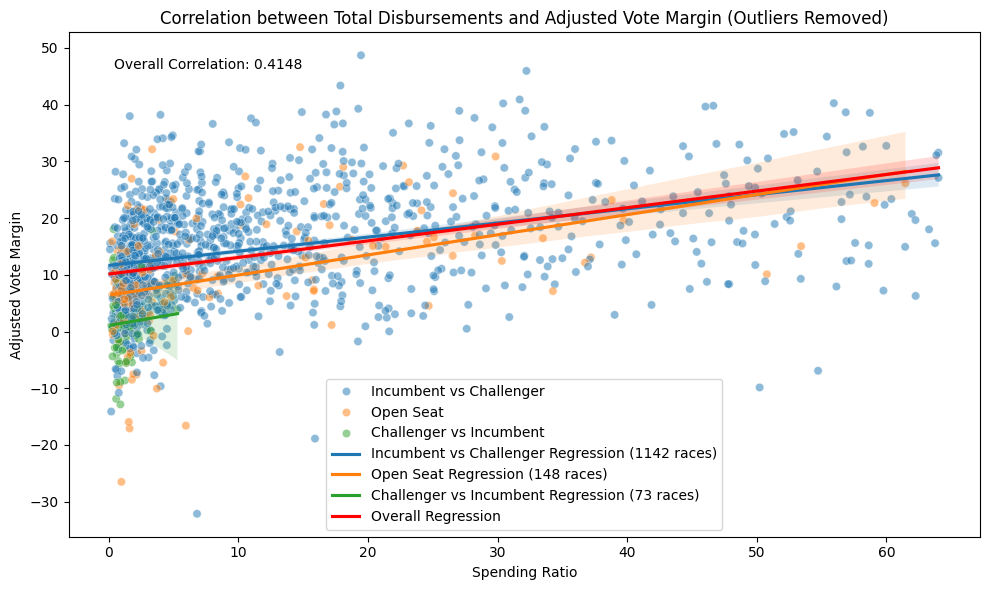

Overall correlation between spending_ratio and adjusted_margin (outliers removed): 0.4148
Number of data points removed as outliers: 244


In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from both spending_ratio and adjusted_margin
df_no_outliers = remove_outliers(df, 'spending_ratio')

# Categorize races based on CAND_ICI columns of the winner and runner up
def categorize_race(row):
    if row['winner_CAND_ICI'] == 'I' and row['runner_up_CAND_ICI'] == 'C':
        return 'Incumbent vs Challenger'
    elif row['winner_CAND_ICI'] == 'O' and row['runner_up_CAND_ICI'] == 'O':
        return 'Open Seat'
    elif row['winner_CAND_ICI'] == 'C' and row['runner_up_CAND_ICI'] == 'I':
        return 'Challenger vs Incumbent'
    else:
        return 'Other'
df_no_outliers['race_type'] = df_no_outliers.apply(categorize_race, axis=1)

# Create a scatter plot with different colors for each race type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='spending_ratio', y='adjusted_margin', hue='race_type', alpha=0.5)

# Add a regression line for each race type
race_types = df_no_outliers['race_type'].unique()
colors = sns.color_palette(n_colors=len(race_types))

for race_type, color in zip(race_types, colors):
    subset = df_no_outliers[df_no_outliers['race_type'] == race_type]
    sns.regplot(data=subset, x='spending_ratio', y='adjusted_margin', scatter=False, color=color, label=f'{race_type} Regression ({len(subset)} races)')

# Add the overall regression line
sns.regplot(data=df_no_outliers, x='spending_ratio', y='adjusted_margin', scatter=False, color='red', label='Overall Regression')

# Set labels and title
plt.xlabel('Spending Ratio')
plt.ylabel('Adjusted Vote Margin')
plt.title('Correlation between Total Disbursements and Adjusted Vote Margin (Outliers Removed)')

# Calculate and display the correlation coefficient
# Calculate and display the overall correlation coefficient
overall_correlation = df_no_outliers['spending_ratio'].corr(df_no_outliers['adjusted_margin'])
plt.text(0.05, 0.95, f'Overall Correlation: {overall_correlation:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')

# Calculate and print the correlation coefficient for each race type
race_type_correlations = {}
for race_type in race_types:
    subset = df_no_outliers[df_no_outliers['race_type'] == race_type]
    correlation = subset['spending_ratio'].corr(subset['adjusted_margin'])
    race_type_correlations[race_type] = correlation
    print(f"Correlation for {race_type}: {correlation:.4f}")

# Adjust layout and display the plot
plt.legend()
plt.tight_layout()
plt.show()

# Print the overall correlation coefficient and the number of removed outliers
print(f"Overall correlation between spending_ratio and adjusted_margin (outliers removed): {overall_correlation:.4f}")
print(f"Number of data points removed as outliers: {len(df) - len(df_no_outliers)}")

# taking the most contested races

In [153]:
df_subset = df[df['adjusted_margin'].abs() < 10]
df_subset = df_subset[df_subset['year'] >= 2012]
print(len(df_subset))

534


In [154]:
# Group by district_id and filter out districts with only one unique year
districts_to_keep = df_subset.groupby('district_id')['year'].nunique() > 1
df_subset = df_subset[df_subset['district_id'].isin(districts_to_keep[districts_to_keep].index)]
print(len(df_subset))

445


In [155]:
# Now drop any remaining rows with NaN values in these columns
df_subset = df_subset.dropna(subset=['winner_CAND_ICI', 'runner_up_CAND_ICI'])
print(len(df_subset))


445


In [156]:
for year in df_subset['year'].unique():
    numberRaces = len(df_subset[df_subset['year'] == year])
    print(year, "---", numberRaces)


2014 --- 74
2018 --- 117
2020 --- 105
2012 --- 77
2016 --- 72


In [157]:
df_subset.to_csv('data/cleaned/most_contested_races.csv', index=False)

# testing

# graphs

In [158]:
df_subset

,race_id,district_id,year,total_votes,winner_name,winner_party,winner_CAND_ICI,runner_up_name,runner_up_party,runner_up_CAND_ICI,margin_of_victory,spending_winner,spending_runner_up,pvi,NHE,spending_ratio,adjusted_margin
2,AK_0_2014,AK_0,2014,279741,DON YOUNG,Republican,I,FORREST DUNBAR,Democrat,C,10.00,809039.20,230088.83,12.0,5.7,3.516204,-7.70
4,AK_0_2018,AK_0,2018,282166,DON YOUNG,Republican,I,ALYSE S GALVIN,Democrat,C,6.58,1387687.05,1943398.59,9.0,-8.6,0.714052,6.18
5,AK_0_2020,AK_0,2020,353165,DON YOUNG,Republican,I,ALYSE S GALVIN,Democrat,C,9.14,1817836.79,5162902.93,9.0,-3.1,0.352096,3.24
43,AR_2_2014,AR_2,2014,237330,FRENCH HILL,Republican,O,PATRICK HENRY HAYS,Democrat,O,8.26,2149743.85,1563841.26,8.0,5.7,1.374656,-5.44
45,AR_2_2018,AR_2,2018,253453,FRENCH HILL,Republican,I,CLARKE TUCKER,Democrat,C,6.31,3536453.22,2359234.62,7.0,-8.6,1.498983,7.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,WA_1_2016,WA_1,2016,349398,SUZAN K DELBENE,Democrat,I,ROBERT J SUTHERLAND,Republican,C,10.83,1625142.38,28942.99,-4.0,1.1,56.149775,7.93
2363,WA_1_2018,WA_1,2018,332743,SUZAN DELBENE,Democrat,I,JEFFREY BEELER,Republican,C,18.54,1558467.49,18808.39,-6.0,-8.6,82.860228,3.94
2364,WA_1_2020,WA_1,2020,426862,SUZAN K DELBENE,Democrat,I,JEFFREY BEELER SR,Republican,C,17.23,1903677.43,62279.24,-6.0,-3.1,30.566806,8.13
2405,WA_8_2018,WA_8,2018,313057,KIM SCHRIER,Democrat,O,DINO ROSSI,Republican,O,4.83,8075093.38,4821393.10,0.0,-8.6,1.674847,-3.77


/tmp/ipykernel_5177/1852432910.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['race_type'] = df_no_outliers.apply(categorize_race, axis=1)


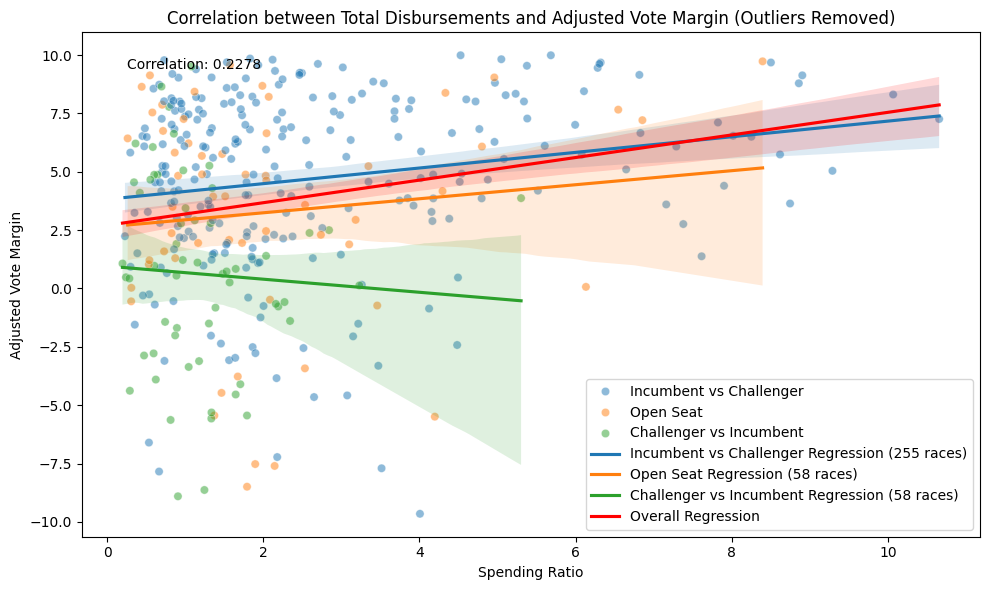

Correlation for Incumbent vs Challenger: 0.1881
Correlation for Open Seat: 0.1146
Correlation for Challenger vs Incumbent: -0.0584
Correlation between spending_ratio and adjusted_margin (outliers removed): -0.0584
Number of data points removed as outliers: 74


In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from both spending_ratio and adjusted_margin
df_no_outliers = remove_outliers(df_subset, 'spending_ratio')

# Categorize races based on CAND_ICI columns of the winner and runner up
def categorize_race(row):
    if row['winner_CAND_ICI'] == 'I' and row['runner_up_CAND_ICI'] == 'C':
        return 'Incumbent vs Challenger'
    elif row['winner_CAND_ICI'] == 'O' and row['runner_up_CAND_ICI'] == 'O':
        return 'Open Seat'
    elif row['winner_CAND_ICI'] == 'C' and row['runner_up_CAND_ICI'] == 'I':
        return 'Challenger vs Incumbent'
    else:
        return 'Other'
df_no_outliers['race_type'] = df_no_outliers.apply(categorize_race, axis=1)

# Create a scatter plot with different colors for each race type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='spending_ratio', y='adjusted_margin', hue='race_type', alpha=0.5)

# Add a regression line for each race type
race_types = df_no_outliers['race_type'].unique()
colors = sns.color_palette(n_colors=len(race_types))

for race_type, color in zip(race_types, colors):
    subset = df_no_outliers[df_no_outliers['race_type'] == race_type]
    sns.regplot(data=subset, x='spending_ratio', y='adjusted_margin', scatter=False, color=color, label=f'{race_type} Regression ({len(subset)} races)')

# Add the overall regression line
sns.regplot(data=df_no_outliers, x='spending_ratio', y='adjusted_margin', scatter=False, color='red', label='Overall Regression')

# Set labels and title
plt.xlabel('Spending Ratio')
plt.ylabel('Adjusted Vote Margin')
plt.title('Correlation between Total Disbursements and Adjusted Vote Margin (Outliers Removed)')

# Adjust layout and display the plot
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print the correlation coefficient for each race type
race_type_correlations = {}
for race_type in race_types:
    subset = df_no_outliers[df_no_outliers['race_type'] == race_type]
    correlation = subset['spending_ratio'].corr(subset['adjusted_margin'])
    race_type_correlations[race_type] = correlation
    print(f"Correlation for {race_type}: {correlation:.4f}")

# Calculate and display the correlation coefficient
overall_correlation = df_no_outliers['spending_ratio'].corr(df_no_outliers['adjusted_margin'])
plt.text(0.05, 0.95, f'Correlation: {overall_correlation:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')

# Print the correlation coefficient and the number of removed outliers
print(f"Correlation between spending_ratio and adjusted_margin (outliers removed): {overall_correlation:.4f}")
print(f"Number of data points removed as outliers: {len(df_subset) - len(df_no_outliers)}")